## What is this?

This Jupyter Notebook contains Python code for building a LSTM Recurrent Neural Network that gives 87-88% accuracy on the IMDB Movie Review Sentiment Analysis Dataset. 

<p align='center'>
    <img src="https://www.bouvet.no/bouvet-deler/explaining-recurrent-neural-networks/_/attachment/inline/dbb03f2e-cfa5-4914-88fd-422231379121:b9e76ed5b43ad981d8e9891158a192ec098c2314/Screenshot%202019-07-11%20at%2016.31.24.png"></img>
</p>

More information is given on [this blogpost](https://www.bouvet.no/bouvet-deler/explaining-recurrent-neural-networks).

We investigate the IMDB Movie Dataset.

<p align="center">
    <img src="https://www.bouvet.no/bouvet-deler/explaining-recurrent-neural-networks/_/attachment/inline/0ad28f07-a532-4a1d-8b0b-c6bc817bb387:78002f0bda06e4dd4d2f70c27c86d4ef2388a7c0/Screenshot%202019-07-04%20at%2013.46.38.png"></img>
</p>

This code is supplied without license, warranty or support. Feel free to do with it what you will.

## Built for Google Collaboratory

Train your network more quickly in Google Collaboratory. From the **Runtime** menu select **Change Runtime** Type and choose "GPU"!

Don't forget to select **Runtime** -> **Restart runtime** to put your changes into effect.

## Setting up

When running this for the first time you may get a warning telling you to restart the Runtime. You can ignore this, but feel free to select "Runtime->Restart Runtime" from the overhead menu if you encounter problems.

In [1]:
# keras.datasets.imdb is broken in TensorFlow 1.13 and 1.14 due to numpy 1.16.3
!pip install numpy==1.16.2

# All the imports!
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.3 MB 11.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.20.2 requires numpy>=1.18, but you have numpy 1.16.2 which is incompatible.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.16.2 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires numpy>=1.20, but you have numpy 1.16.2 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.16.2 which is incompatible.
scikit-image 0.18.3 requires numpy>=1.16.5, but you have numpy 1.16.2 which is incompatible.
pywavelets 1.3.0 requires numpy>=1.17.3, but you

17473536/17464789 [==============================] - 0s 0us/step


### Vocabulary Size

In [90]:
# Fetch "IMDB Movie Review" data, constraining our reviews to 
# the 10000 most commonly used words
vocab_size = 5000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

# Map for readable classnames
class_names = ["Negative", "Positive"]

## Create map for converting IMDB dataset to readable reviews

Reviews in the IMDB dataset have been encoded as a sequence of integers. Luckily the dataset also 
contains an index for converting the reviews back into human readable form.

In [91]:
# Get the word index from the dataset
word_index = tf.keras.datasets.imdb.get_word_index()

# Ensure that "special" words are mapped into human readable terms 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Perform reverse word lookup and make it callable
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

## Data Insight

Here we take a closer look at our data. How many words do our reviews contain?

And what do our review look like in machine and human readable form?


In [92]:
# Concatonate test and training datasets
allreviews = np.concatenate((x_train, x_test), axis=0)

# Review lengths across test and training whole datasets
print("Maximum review length: {}".format(len(max((allreviews), key=len))))
print("Minimum review length: {}".format(len(min((allreviews), key=len))))
result = [len(x) for x in allreviews]
print("Mean review length: {}".format(np.mean(result)))

# Print a review and it's class as stored in the dataset. Replace the number
# to select a different review.
print("")
print("Machine readable Review")
print("  Review Text: " + str(x_train[60]))
print("  Review Sentiment: " + str(y_train[60]))

# Print a review and it's class in human readable format. Replace the number
# to select a different review.
print("")
print("Human Readable Review")
print("  Review Text: " + decode_review(x_train[60]))
print("  Review Sentiment: " + class_names[y_train[60]])

Maximum review length: 2494
Minimum review length: 7
Mean review length: 234.75892

Machine readable Review
  Review Text: [1, 13, 219, 14, 33, 4, 2, 22, 1413, 12, 16, 373, 175, 2711, 1115, 1026, 430, 939, 16, 23, 2444, 25, 43, 697, 89, 12, 16, 170, 8, 130, 262, 19, 32, 4, 665, 7, 4, 2, 322, 5, 4, 1520, 7, 4, 86, 250, 10, 10, 4, 249, 173, 16, 4, 3891, 6, 19, 4, 167, 564, 5, 564, 1325, 36, 805, 8, 216, 638, 17, 2, 21, 25, 100, 376, 507, 4, 2110, 15, 79, 125, 23, 567, 13, 2134, 233, 36, 4852, 2, 5, 81, 1672, 10, 10, 92, 437, 129, 58, 13, 69, 8, 401, 61, 1432, 39, 1286, 46, 7, 12]
  Review Sentiment: 0

Human Readable Review
  Review Text: <START> i saw this at the <UNKNOWN> film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director writer and writer producer they tried to come across as <UNKNOWN> 

## Pre-processing Data

We need to make sure that our reviews are of a uniform length. This is for the LSTM's parameters.

<p align='center'><img src='https://miro.medium.com/max/805/1*0CJgssFgShpKAi5ITSuM5w.png' width=300></img></p>

Some reviews will need to be truncated, while others need to be padded.

In [93]:
# The length of reviews
review_length = 300

# Padding / truncated our reviews
x_train = sequence.pad_sequences(x_train, maxlen = review_length)
x_test = sequence.pad_sequences(x_test, maxlen = review_length)

# Check the size of our datasets. Review data for both test and training should 
# contain 25000 reviews of 500 integers. Class data should contain 25000 values, 
# one for each review. Class values are 0 or 1, indicating a negative 
# or positive review.
print("Shape Training Review Data: " + str(x_train.shape))
print("Shape Training Class Data: " + str(y_train.shape))
print("Shape Test Review Data: " + str(x_test.shape))
print("Shape Test Class Data: " + str(y_test.shape))

# Note padding is added to start of review, not the end
print("")
print("Human Readable Review Text (post padding): " + decode_review(x_train[60]))

Shape Training Review Data: (25000, 300)
Shape Training Class Data: (25000,)
Shape Test Review Data: (25000, 300)
Shape Test Class Data: (25000,)

Human Readable Review Text (post padding): <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

## Create and build LSTM Recurrent Neural Network

### Embedding

Embedding layer turns positive integers (indexes) into dense vectors of fixed size.

```
eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
```

<p align='center'><img src='https://github.com/yiqiao-yin/WYNAssociates/blob/main/figs/layer_embedding.png?raw=true' width=600></img></p>


In [94]:
# We begin by defining the a empty stack. We'll use this for building our 
# network, later by layer.
model = tf.keras.models.Sequential()

# The Embedding Layer provides a spatial mapping (or Word Embedding) of all the 
# individual words in our training set. Words close to one another share context 
# and or meaning. This spatial mapping is learning during the training process.
model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = 64, # Dimensions to which each words shall be mapped
        input_length = review_length # Length of input sequences
    )
)

Recall the dimension of the input data.

In [95]:
# display shape
x_train.shape

(25000, 300)

These are the arguments required. Vocabulary size is define above. Review length is the length of the features, which is also defined above. The output dimension is a choice by the scientist.

In [96]:
# recall args
vocab_size, review_length

(5000, 300)

We can generate output without training anything. This will not be a trained model. However, the dimension should match and the *.predict()* function should work.

In [97]:
# test
some_fake_test_ = model.predict(x_train)
some_fake_test_.shape

(25000, 300, 64)

### Dropout

Simply put, dropout refers to ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random. By “ignoring”, I mean these units are not considered during a particular forward or backward pass.

Given that we know a bit about dropout, a question arises — why do we need dropout at all? Why do we need to literally shut-down parts of a neural networks?

The answer to these questions is “to prevent over-fitting”.

A fully connected layer occupies most of the parameters, and hence, neurons develop co-dependency amongst each other during training which curbs the individual power of each neuron leading to over-fitting of training data.

<p align='center'><img src='https://miro.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png' width=600></img></p>

More see this [blog](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5).

### LSTM

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

<p align='center'><img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png' width=600></img></p>


LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<p align='center'><img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png' width=600></img></p>

The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.

<p align='center'><img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png' width=600></img></p>

Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation.

<p align='center'><img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-gate.png' width=100></img></p>

The first step in our LSTM is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “forget gate layer.”

<p align='center'><img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png' width=600></img></p>

The next step is to decide what new information we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “input gate layer” decides which values we’ll update. Next, a tanh layer creates a vector of new candidate values that could be added to the state.

<p align='center'><img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png' width=600></img></p>

It’s now time to update the old cell state and into the new cell state. The previous steps already decided what to do, we just need to actually do it.

<p align='center'><img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png' width=600></img></p>

Finally, we need to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.

<p align='center'><img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png' width=600></img></p>

More can be read in this [blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).




## Build the Model

In [98]:
# We begin by defining the a empty stack. We'll use this for building our 
# network, later by layer.
model = tf.keras.models.Sequential()

# The Embedding Layer provides a spatial mapping (or Word Embedding) of all the 
# individual words in our training set. Words close to one another share context 
# and or meaning. This spatial mapping is learning during the training process.
model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = 16, # Dimensions to which each words shall be mapped
        input_length = review_length # Length of input sequences
    )
)

# Dropout layers fight overfitting and forces the model to learn multiple 
# representations of the same data by randomly disabling neurons in the 
# learning phase.
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

# We are using a fast version of LSTM whih is optimised for GPUs. This layer 
# looks at the sequence of words in the review, along with their word embeddings
# and uses both of these to determine to sentiment of a given review.
model.add(
    tf.keras.layers.LSTM(
        units=32 # 32 LSTM units in this layer
    )
)

# Add a second dropout layer with the same aim as the first.
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

# All LSTM units are connected to a single node in the dense layer. A sigmoid 
# activation function determines the output from this node - a value 
# between 0 and 1. Closer to 0 indicates a negative review. Closer to 1 
# indicates a positive review.
model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)

# Compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric

# Display a summary of the models structure
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 300, 16)           80000     
                                                                 
 dropout_14 (Dropout)        (None, 300, 16)           0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 86,305
Trainable params: 86,305
Non-trainable params: 0
_________________________________________________________________


## Visualise the Model

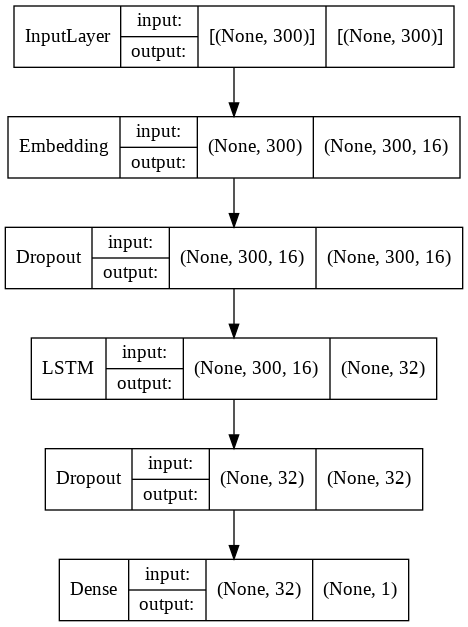

In [99]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

## Train the LSTM

In [100]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()

In [101]:
# Train the LSTM on the training data
with tf.device('/device:GPU:0'):
    history = model.fit(

        # Training data : features (review) and classes (positive or negative)
        x_train, y_train,
                        
        # Number of samples to work through before updating the 
        # internal model parameters via back propagation. The 
        # higher the batch, the more memory you need.
        batch_size=256, 

        # An epoch is an iteration over the entire training data.
        epochs=10, 
        
        # The model will set apart his fraction of the training 
        # data, will not train on it, and will evaluate the loss
        # and any model metrics on this data at the end of 
        # each epoch.
        validation_split=0.2,
        
        # Set verbose=1 if it is desired to have output printed.
        # In some scenarios where output needs to be hidden, we
        # set verbose=0.
        verbose=1
    ) 

Epoch 1/10
79/79 [==============================] - 4s 23ms/step - loss: 0.6472 - accuracy: 0.6175 - val_loss: 0.4827 - val_accuracy: 0.8092
Epoch 2/10
79/79 [==============================] - 1s 17ms/step - loss: 0.3982 - accuracy: 0.8364 - val_loss: 0.3283 - val_accuracy: 0.8692
Epoch 3/10
79/79 [==============================] - 1s 17ms/step - loss: 0.2894 - accuracy: 0.8891 - val_loss: 0.2953 - val_accuracy: 0.8806
Epoch 4/10
79/79 [==============================] - 1s 17ms/step - loss: 0.2405 - accuracy: 0.9107 - val_loss: 0.2947 - val_accuracy: 0.8766
Epoch 5/10
79/79 [==============================] - 1s 17ms/step - loss: 0.2231 - accuracy: 0.9177 - val_loss: 0.2873 - val_accuracy: 0.8810
Epoch 6/10
79/79 [==============================] - 1s 16ms/step - loss: 0.1966 - accuracy: 0.9278 - val_loss: 0.2940 - val_accuracy: 0.8780
Epoch 7/10
79/79 [==============================] - 1s 16ms/step - loss: 0.1820 - accuracy: 0.9356 - val_loss: 0.2894 - val_accuracy: 0.8820
Epoch 8/10
79

## Evaluate model with test data and view results

In [102]:
# Get Model Predictions for test data
from sklearn.metrics import classification_report
predicted_classes = model.predict(x_test)

In [103]:
predicted_classes = (predicted_classes > 0.5).astype(int)

In [104]:
print(classification_report(y_test, predicted_classes, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.87      0.86      0.87     12500
    Positive       0.86      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



## View some incorrect predictions

Lets have a look at some of the incorrectly classified reviews. For readability we remove the padding.



In [105]:
predicted_classes_reshaped = np.reshape(predicted_classes, 25000)

incorrect = np.nonzero(predicted_classes_reshaped!=y_test)[0]

# We select the first 10 incorrectly classified reviews
for j, incorrect in enumerate(incorrect[0:20]):
    
    predicted = class_names[predicted_classes_reshaped[incorrect]]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])
    
    print("Incorrectly classified Test Review ["+ str(j+1) +"]") 
    print("Test Review #" + str(incorrect)  + ": Predicted ["+ predicted + "] Actual ["+ actual + "]")
    print("Test Review Text: " + human_readable_review.replace("<PAD> ", ""))
    print("")

Incorrectly classified Test Review [1]
Test Review #2: Predicted [Negative] Actual [Positive]
Test Review Text: alive <UNKNOWN> while <UNKNOWN> for his part is depicted as a <UNKNOWN> white <UNKNOWN> guy in the <UNKNOWN> who looks like he'd rather be taking a <UNKNOWN> when <UNKNOWN> sends them a tree like god who <UNKNOWN> them the <UNKNOWN> decide that this is no improvement and demand a different king <UNKNOWN> <UNKNOWN> sends them a <UNKNOWN> br br <UNKNOWN> with this <UNKNOWN> looking new king who <UNKNOWN> above them the <UNKNOWN> welcome him with a <UNKNOWN> of <UNKNOWN> dressed <UNKNOWN> the mayor steps forward to hand him the key to the <UNKNOWN> as <UNKNOWN> cameras record the event to everyone's horror the <UNKNOWN> <UNKNOWN> <UNKNOWN> the mayor and then goes on a <UNKNOWN> <UNKNOWN> <UNKNOWN> <UNKNOWN> at random a title card <UNKNOWN> reads news of the king's <UNKNOWN> throughout the kingdom when the now <UNKNOWN> <UNKNOWN> once more <UNKNOWN> <UNKNOWN> for help he loses hi

## Run your own text against the trained model

This is a fun way to test out the limits of the trained model. To avoid getting errors - type in lower case only and do not use punctuation! 

You'll see the raw prediction from the model - basically a value between 0 and 1.



In [106]:
# Write your own review
# review = "this was a terrible film with too much sex and violence i walked out halfway through"
review = "this is the best film i have ever seen it is great and fantastic and i loved it"
#review = "this was an awful film that i will never see again"

# Encode review (replace word with integers)
tmp = []
for word in review.split(" "):
    tmp.append(word_index[word])

# Ensure review is 500 words long (by padding or truncating)
tmp_padded = sequence.pad_sequences([tmp], maxlen=review_length) 

# Run your processed review against the trained model
rawprediction = model.predict(array([tmp_padded][0]))[0][0]
prediction = int(round(rawprediction))

# Test the model and print the result
print("Review: " + review)
print("Raw Prediction: " + str(rawprediction))
print("Predicted Class: " + class_names[prediction])

Review: this is the best film i have ever seen it is great and fantastic and i loved it
Raw Prediction: 0.9894929
Predicted Class: Positive
